In [1]:
from scipy.special import gamma
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import fsolve, root
from scipy.optimize import minimize
import scipy.integrate
import matplotlib.pyplot as plt

#read in data
_df = pd.read_csv("/home/niyu/Documents/794/794Project/SPY.csv")
_df.index = _df.iloc[:,0]
df = _df.iloc[:,5:6] 

def log_return():
    l_r = np.log(df/df.shift(1))
    l_r.fillna(0,inplace = True)
    return l_r

LR = log_return()

In [2]:
class Meixner:
    """
    Defining Meixner process model
    """
    def __init__(self,parameters):
        """a > 0, −π < b < π, d > 0, and m ∈ R.
        """
        self.a=parameters[0]
        self.b=parameters[1]
        self.d=parameters[2]
        self.m=parameters[3]
        # new m under EMM by mean correcting
    
    def pdf(self,x):
        z = (x-self.m)/self.a
        density = (2*np.cos(self.b/2))**(2*self.d)/(2*self.a*np.pi*gamma(2*self.d))*np.exp(self.b*z)*abs(gamma(self.d+z*1j))**2
        return density
    
    def mean(self):
        return self.m+self.a*self.d*np.tan(self.b/2)
    
    def var(self):
        return self.a**2*self.d/(np.cos(self.b)+1)
    
    def skew(self):
        return np.sin(self.b)*(self.d*(np.cos(self.b)+1))*-0.5
    
    def kurt(self):
        return 3+(2-np.cos(self.b))/self.d
    
#    def m_riskneutral

print('Mexiner Process Defined')

Mexiner Process Defined


In [3]:
def MomentEstimator():
    """ the moment estimator method to get the parameters a,b,d,m
    """
#    by this data set, the result is:[ 0.01269828  0.58355268  0.83624537 -0.00274537]
    mean = LR.mean()
    var = LR.var()
    skew = LR.skew()
    kurt = LR.kurt()
    
    def fun(x):
        """ x is the parameter vector
        """
        MXN = Meixner(x)
        return np.array([float(MXN.mean()-mean), float(MXN.var()-var), float(MXN.skew()-skew), float(MXN.kurt()-kurt)])
    
    x0 = np.array([0.01,0,1,0])
    result = fsolve(fun,x0)
   
    return result


def OBJ(para):
    """ para: an array of Meixner parameters; 
        since we use min to achieve max, we need to multipy -1 to obj
    """
    MXN = Meixner(para)
    PDFvector = np.array([MXN.pdf(x) for x in np.array(LR)])
    return -1*sum(np.log(PDFvector))


In [4]:
def MLE():
    """
    Maximizing the OBJ and find the best estimation of parameters in Meixner
    """
    # the value of the OBJ can get really large, so choose the para from moment estimator as the initial
    # value, or the arbitray choosing may lead run time error when optimal
    initial = np.array([ 0.01294108, 0.49220911,  1.03397087, -0.00280419])
    b1 = np.array([(0.0001,None),(-np.pi, np.pi),(0.0001,None),(None,None)])
    return minimize(OBJ,initial,method ='L-BFGS-B',bounds=b1) 

def para_plot():
    """ this is the figure of data pdf, Meixner pdf of two kinds of parameters from two method
    """
    sns.set_style('darkgrid')
    sns.set_context('paper')
    sns.distplot(LR,hist = True,label = 'Real Data', axlabel = 'daily returns')

# the moment estimator parameters:
    MEpara = MomentEstimator()
    sample1 = Meixner(MEpara)
    print('Moment Estimator parameters(a,b,d,m):\n', MEpara)

# the most likelihood estimator parameters:
    MLEpara = MLE().x
    sample2 = MXN_EMM(MLEpara)
    print('Most Likelihood Estimator parameters(a,b,d,m):\n', MLEpara)
    
    def PdfPlot():
        x = np.linspace(-0.05,0.05,10000)
        plt.plot(x,sample1.pdf(x))
        plt.plot(x,sample2.pdf(x))
        plt.plot(x,sample2.pdf_EMM(x))
        plt.legend(['Moment Estimator','Most Likelihood Estimator','MLE_EMM'])
    PdfPlot()
    
    return sample2

In [5]:
class MXN_EMM(Meixner):
    def __init__(self,parameters,r=0.024):
        Meixner.__init__(self,parameters)
        self.r = r
        self.m_rn = self.r-2*self.d*np.log(np.cos(self.b/2)/np.cos((self.a+self.b)/2))

    def pdf_EMM(self,x):
        z = (x-self.m_rn)/self.a
        density = (2*np.cos(self.b/2))**(2*self.d)/(2*self.a*np.pi*gamma(2*self.d))*np.exp(self.b*z)*abs(gamma(self.d+z*1j))**2
        return density
    

class EurPricing(MXN_EMM):
    """
    European Option Pricing class
    """
    def __init__(self,parameters,T=3/252,S0=293.41,alpha=7,N=512,deltak=0.005):
        """ Aprial 26,
        """
        MXN_EMM.__init__(self,parameters,r=0.024)
        self.T = T
        self.S0 = S0
        self.alpha = alpha
        self.N = N
        self.deltak = deltak
    
    def ChFun(self,u):
        """ the characteristic function of Meixner distribution
        """
        result = (np.cos(self.b/2)/np.cosh(0.5*(self.a*u-self.b*1j)))**(2*self.d*self.T)*np.exp(self.m_rn*self.T*u*1j)
        return result
        
    def CFprice(self,niu):
        """ this is pusai, the character function/ Fourier Transform of price tide_CT(k)
        """
        pusai = np.exp(-self.r*self.T)/((self.alpha+niu*1j)*(self.alpha+1+niu*1j))*self.ChFun(niu-(self.alpha+1)*1j)*np.exp(1j*(niu-(self.alpha+1)*1j)*np.log(self.S0))
        return pusai
    
    def xVector(self):
        deltaniu = 2*np.pi/(self.N*self.deltak)
        niu = np.array([i*deltaniu for i in range(self.N)])
        w = np.array([deltaniu/2 if i == 0 else deltaniu for i in range(self.N)])
        beta = np.log(self.S0) - self.deltak*self.N/2
        x = np.exp(-1j*niu*beta)*self.CFprice(niu)*w
        return np.fft.fft(x)
    
    def Price(self):
        beta = np.log(self.S0) - self.deltak*self.N/2
        # k is logStrike sequence
        k = np.array([beta + i*self.deltak for i in range(self.N)])
        price = np.exp(-self.alpha*k)*self.xVector().real/np.pi       
        return price, np.exp(k)

In [6]:
if __name__ == '__main__':
    print('The MLE estimation of Meixner paras:')
    print(MLE())

The MLE estimation of Meixner paras:
      fun: array([-8386.02358987])
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00873115, 0.00200089, 0.00491127, 0.95551513])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 315
      nit: 47
   status: 0
  success: True
        x: array([ 0.03128697, -0.22078348,  0.1886354 ,  0.0012112 ])


In [7]:
    print('The Moment estimation of Meixner paras:')
    print(MomentEstimator())

The Moment estimation of Meixner paras:
[ 0.01294108  0.49220911  1.03397087 -0.00280419]


In [9]:
    print("Passing parameters to Meixner model...")
    sample=EurPricing(np.array([0.03128716,-0.22078567,0.18863356,0.00121117]))
    
    print("information about contructed Meixner distribution:")
    print('mean: ',sample.mean())
    print('var: ',sample.var())
    print('skew: ',sample.skew())
    print('kurt: ',sample.kurt())

Passing parameters to Meixner model...
information about contructed Meixner distribution:
mean:  0.0005569930879317673
var:  9.345974678353535e-05
skew:  0.040808663179688974
kurt:  8.429968603250666


/home/niyu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Moment Estimator parameters(a,b,d,m):
 [ 0.01294108  0.49220911  1.03397087 -0.00280419]
Most Likelihood Estimator parameters(a,b,d,m):
 [ 0.03128697 -0.22078348  0.1886354   0.0012112 ]


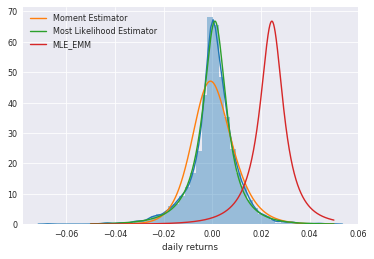

In [10]:
    sample=para_plot()